# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика F1 score.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.tsv` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.tsv` должен включать в себя колонку title, содержащую те же данные, что и исходный файл `test.tsv`, а также колонку is_fake, содержащую значения 0 или 1.
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

In [20]:
# NLP related
import nltk
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Others
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Работа с данными

### Загрузка данных

In [2]:
train = pd.read_csv('dataset/train.tsv', sep='\t')
test = pd.read_csv('dataset/test.tsv', sep='\t')

In [3]:
train.head(3)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1


### EDA

Предобработка текстовых данных сильно влияет на качество итогового решения.

Преобразования, которые могут улучшить качество: 

1) Привести слова к нижнему регистру

2) Удалить знаки препинания и числа

3) Токенизировать текст

4) Лемматизация (приведение слова к нормальной форме)

In [5]:
nltk.download('punkt')
nltk.download('wordnet')

morph = MorphAnalyzer()

[nltk_data] Downloading package punkt to /Users/madina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/madina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def preprocess(text):
    # 1, 2, 3
    tokens = list(filter(str.isalpha, word_tokenize(text.lower(), language='russian')))
    # 4
    tokens = [parsed[0].normal_form for parsed in map(morph.parse, tokens)]
    return tokens

In [7]:
# Проверка предобработки
preprocess('Москвичу Владимиру пришёл счёт за воду.')

['москвич', 'владимир', 'прийти', 'счёт', 'за', 'вода']

In [8]:
train['data'] = train.apply(lambda row: preprocess(row.title), axis=1)

### Разбиение данных

Для локального тестирования разобьем обучающую выборку на обучающую и валидационную

In [10]:
train, val = train_test_split(train, test_size=0.1, random_state=42)

# План работы

Рассмотрим несколько методов обработки текстовых данных, в порядке их усложнения.

1) Сначала получим tf-idf векторы текстов и обучим на них обычный классфикатор

2) Затем будем обрабатывать каждый токен отдельно. Для этого векторные представления токенов получим с помощью Word2Vec и рассмотрим несколько подходов к их агрегированнию. На полученных векторных представлениях также обучим классификатор.

3) Наконец, воспользуемся сложной моделью. А именно, попробуем дообучить предобученный BERT с головой-классификатором на наших текстах.

# Часть 1: Классификация на tf-idf векторах

Для `TfidfVectorizer` нужно сначала склеить токены в предложения:

In [12]:
train_text = train.data.apply(' '.join)
val_text = val.data.apply(' '.join)

Получим tf-idf векторы наших текстов:

In [13]:
tf_idf = TfidfVectorizer(lowercase=False).fit(train_text)

Подготовим данные для обучения:

In [14]:
X_train = tf_idf.transform(train_text)
X_val = tf_idf.transform(val_text)
y_train = train.is_fake
y_val = val.is_fake

### Логистическая регрессия

Сразу подберем коэффициент регуляризации с помощью валидации по отложенной выборке.

In [23]:
best_C = 0.
best_f1 = 0.

C_range = np.logspace(3, 5, num=10)

for C in tqdm(C_range, desc='Validating', ncols=80):
    model = LogisticRegression(C=C)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model.fit(X_train, y_train)
    pred = model.predict(X_val)
    f1 = f1_score(y_val, pred)
    if f1 > best_f1:
        best_C = C
        best_f1 = f1

Validating: 100%|███████████████████████████████| 10/10 [00:01<00:00,  6.28it/s]


In [27]:
best_C

59948.42503189409

In [34]:
f1_logreg = best_f1
print('Значения F1 метрики\n')
print(f'Логистическая регрессия: {f1_logreg}')

Значения F1 метрики

Логистическая регрессия: 0.8407224958949097


### SVM

Как и в случае с логистической регрессией, будем подбирать коэффициент регуляризации. Также, попробуем разные виды SVM, чтобы найти лучший: линейный и ядровой (ядра также попробуем разные)

In [37]:
best_C = 0.
best_kernel = ''
best_f1 = 0.

C_range = np.logspace(0, 2, num=10)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for C in tqdm(C_range, desc='Validating', ncols=80):
    for kernel in kernels:
        model = SVC(C=C, kernel=kernel)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train, y_train)
        pred = model.predict(X_val)
        f1 = f1_score(y_val, pred)
        if f1 > best_f1:
            best_C = C
            best_f1 = f1
            best_kernel = kernel

Validating: 100%|███████████████████████████████| 10/10 [01:26<00:00,  8.65s/it]


In [38]:
best_C, best_kernel

(2.7825594022071245, 'rbf')

In [40]:
f1_svm = best_f1
print('Значения F1 метрики\n')
print(f'Логистическая регрессия: {f1_logreg}')
print(f'SVM + RBF ядро: {f1_svm}')

Значения F1 метрики

Логистическая регрессия: 0.8407224958949097
SVM + RBF ядро: 0.8571428571428572


### Итоги части

Лучшее качество на tf-idf векторах получилось достичь с помощью ядрового SVM с RBF ядром.

In [41]:
f1_1 = f1_svm

# Часть 2: Word2Vec

Попробуем обучить лучший классификатор из предыдущей части на векторных представлениях Word2Vec, агрегированных разными способами.

Но для начала получим представления W2V.

In [44]:
w2v = Word2Vec(train.data.values).wv

In [47]:
vocabulary = dict(zip(w2v.index_to_key, w2v.vectors))

### Усредненные W2V векторы

Первый способ агрегации из тех, что мы рассмотрим - усреднить векторные представления W2V для каждого предложения по его токенам.

In [54]:
class mean_vectorizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.dim = len(next(iter(vocab.values())))

    def transform(self, X):
        return np.array([
            np.mean([self.vocab[tok] for tok in tokens if tok in self.vocab] 
                    or [np.zeros(self.dim)], axis=0)
            for tokens in X
        ])

### Среднее взвешенных W2V векторов

Просто усредняя векторные представления Word2Vec, мы не учитываем то, что величина вклада каждого слова в смысл предложения может быть разной. Для того, чтобы это учесть, рассмотрим среднее взвешенных W2V представлений токенов одного предложения с весами, равными idf этих токенов.

In [70]:
def calc_idf(documents):
    # number of documents
    n = len(documents)    
    # extract distinct tokens
    tokens = set()
    tokens = tokens.union(*[set(sent) for sent in documents])
    # counting
    counts = dict.fromkeys(tokens, 0)
    for sent in documents:
        sent_distinct = set(sent)
        for tok in sent_distinct:
            counts[tok] += 1
    # idf
    idf = dict(zip(
        counts.keys(), 
        np.log(n / np.array(list(counts.values()))).tolist()
        ))
    return idf

In [82]:
class idf_vectorizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.dim = len(next(iter(vocab.values())))
        self.idf = None

    def fit(self, X):
        self.idf = calc_idf(X)
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.vocab[tok] * self.idf[tok]
                     for tok in tokens if tok in self.vocab] 
                    or [np.zeros(self.dim)], axis=0)
            for tokens in X
        ])

### Эксперимент с размерностью эмбеддингов

In [109]:
def try_size(sizes):
    mean_val_f1 = []
    idf_val_f1 = []
    best_mean_f1 = 0.
    best_mean_size = 0
    best_idf_f1 = 0.
    best_idf_size = 0
    
    for size in tqdm(sizes, desc='Trying sizes', ncols=80):
        # обучаем w2v
        w2v = Word2Vec(train.data.values, vector_size=size).wv
        vocabulary = dict(zip(w2v.index_to_key, w2v.vectors))
        
        # усредненный w2v
        mv = mean_vectorizer(vocabulary)
        X_train = mv.transform(train.data.values)
        X_val = mv.transform(val.data.values)
        
        model = SVC(kernel='rbf').fit(X_train, y_train)
        pred = model.predict(X_val)
        mean_val_f1 += [f1_score(y_val, pred)]

        if mean_val_f1[-1] > best_mean_f1:
            best_mean_f1 = mean_val_f1[-1]
            best_mean_size = size
        
        # взвешенный idf
        idf_w2v = idf_vectorizer(vocabulary).fit(train.data.values)
        X_train = idf_w2v.transform(train.data.values)
        X_val = idf_w2v.transform(val.data.values)
        
        model = SVC(kernel='rbf').fit(X_train, y_train)
        pred = model.predict(X_val)
        idf_val_f1 += [f1_score(y_val, pred)]

        if idf_val_f1[-1] > best_idf_f1:
            best_idf_f1 = idf_val_f1[-1]
            best_idf_size = size
        
    print(f'Best val F1, mean W2V: {best_mean_f1:.4f}, for size: {best_mean_size}')
    print(f'Best val F1, W2V + idf: {best_idf_f1:.4f}, for size: {best_idf_size}')
    return mean_val_f1, idf_val_f1

In [110]:
def plot_metrics(sizes, mean_val_f1, idf_val_f1):
    plt.figure(figsize=(12, 4))

    plt.plot(sizes, mean_val_f1, label='Усредненные W2V')
    plt.plot(sizes, idf_val_f1, label='W2V + idf')
    plt.ylabel('F1')
    
    plt.grid()
    plt.xlabel('Размер эмбеддинга')
    plt.legend()

    plt.tight_layout()

In [111]:
sizes = range(100, 601, 50)
scores = try_size(sizes)

Trying sizes: 100%|█████████████████████████████| 11/11 [02:40<00:00, 14.59s/it]

Best val F1, mean W2V: 0.6728, for size: 300
Best val F1, W2V + idf: 0.6987, for size: 450


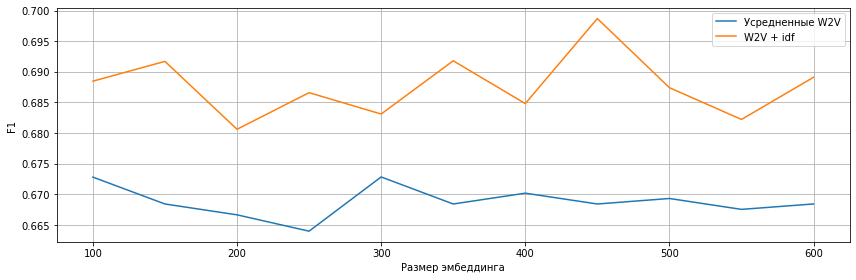

In [112]:
plot_metrics(sizes, *scores)

### Подбор коэффициента регуляризации

Лучшим оказался подход со средним взвешенных W2V представлений размерности 450.

In [113]:
w2v = Word2Vec(train.data.values, vector_size=450).wv
idf_w2v = idf_vectorizer(vocabulary).fit(train.data.values)

X_train = idf_w2v.transform(train.data.values)
X_val = idf_w2v.transform(val.data.values)

Обучим классификатор и подберем коэффициент регуляризации.

In [114]:
best_C = 0.
best_f1 = 0.

C_range = np.logspace(-2, 1, num=10)

for C in tqdm(C_range, desc='Validating', ncols=80):
    model = SVC(C=C, kernel='rbf')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model.fit(X_train, y_train)
    pred = model.predict(X_val)
    f1 = f1_score(y_val, pred)
    if f1 > best_f1:
        best_C = C
        best_f1 = f1

Validating: 100%|███████████████████████████████| 10/10 [00:24<00:00,  2.47s/it]


In [115]:
best_C

0.46415888336127775

In [117]:
f1_w2v = best_f1
print('Значения F1 метрики\n')
print(f'SVM + RBF ядро на tf-idf векторах: {f1_1}')
print(f'SVM + RBF ядро на W2V + idf: {f1_w2v}')

Значения F1 метрики

SVM + RBF ядро на tf-idf векторах: 0.8571428571428572
SVM + RBF ядро на W2V + idf: 0.6949806949806949


### Итоги части

Качество лучшей модели на агрегированных W2V сильно уступает качеству лучшей модели из предыдущей части.

In [121]:
f1_best = f1_1